# Week 6: Multi-Class Land Cover Classification and Model Generalization

This lab extends last week's binary forest classification to a **four-class problem**: forest, agriculture, urban, and water. We'll explore training data design, feature engineering with spectral indices, spatial cross-validation, and model transfer to a new geography (Damascus, Syria).

**Objectives:**
- Design training data for multi-class classification
- Engineer spectral indices (NDVI, MNDWI, NDBI) as features
- Evaluate with appropriate multi-class metrics
- Implement spatial cross-validation with GroupKFold
- Test model generalization to a new region

In [1]:
# Imports
from datetime import datetime, timedelta

import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
import pystac_client
import rioxarray  # noqa: F401
import xarray as xr
from dask.distributed import Client
from odc.geo.geobox import GeoBox
from shapely.geometry import Polygon
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import GroupKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

client = Client(processes=False)

/home/nissim/Documents/dev/musa-650-spring-2026/.venv/lib/python3.11/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34113 instead
  warnings.warn(


/home/nissim/Documents/dev/musa-650-spring-2026/.venv/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


---
## Data Acquisition

We reuse Vienna Sentinel-2 data from Week 5, but now load additional bands needed for spectral indices.

In [2]:
# Define spatial and temporal extent for Vienna
dx = 0.0006  # ~60m resolution
epsg = 4326

# Vienna area bounds
vienna_bounds = (16.32, 47.86, 16.9, 48.407)

# Temporal extent: May 2024
start_date = datetime(year=2024, month=5, day=1)
end_date = start_date + timedelta(days=10)

date_query = f"{start_date.strftime('%Y-%m-%d')}/{end_date.strftime('%Y-%m-%d')}"

# Search for Sentinel-2 data
stac_client = pystac_client.Client.open("https://earth-search.aws.element84.com/v1")

vienna_items = stac_client.search(
    bbox=vienna_bounds,
    collections=["sentinel-2-l2a"],
    datetime=date_query,
    limit=100,
).item_collection()

print(f"Vienna: {len(vienna_items)} scenes found")

# Create geobox and load data (including SWIR for water index)
vienna_geobox = GeoBox.from_bbox(vienna_bounds, crs=f"epsg:{epsg}", resolution=dx)

dc_vienna = odc.stac.load(
    vienna_items,
    bands=["scl", "red", "green", "blue", "nir", "swir16"],
    chunks={"time": 5, "x": 600, "y": 600},
    geobox=vienna_geobox,
    resampling="bilinear",
)
dc_vienna

Vienna: 10 scenes found


<xarray.Dataset> Size: 97MB
Dimensions:      (latitude: 913, longitude: 967, time: 10)
Coordinates:
  * latitude     (latitude) float64 7kB 48.41 48.41 48.41 ... 47.86 47.86 47.86
  * longitude    (longitude) float64 8kB 16.32 16.32 16.32 ... 16.9 16.9 16.9
  * time         (time) datetime64[ns] 80B 2024-05-01T09:57:21.858000 ... 202...
    spatial_ref  int32 4B 4326
Data variables:
    scl          (time, latitude, longitude) uint8 9MB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>
    red          (time, latitude, longitude) uint16 18MB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>
    green        (time, latitude, longitude) uint16 18MB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>
    blue         (time, latitude, longitude) uint16 18MB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>
    nir          (time, latitude, longitude) uint16 18MB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>
    swir16       (time, latitude, longitude) uint16 18MB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>

In [3]:
# Cloud masking


def is_valid_pixel(data):
    """Include vegetated, not_vegetated, water, and snow pixels (SCL classes 4-6 and 11)"""
    return ((data > 3) & (data < 7)) | (data == 11)


valid_mask = is_valid_pixel(dc_vienna.scl)
dc_valid = dc_vienna.where(valid_mask)

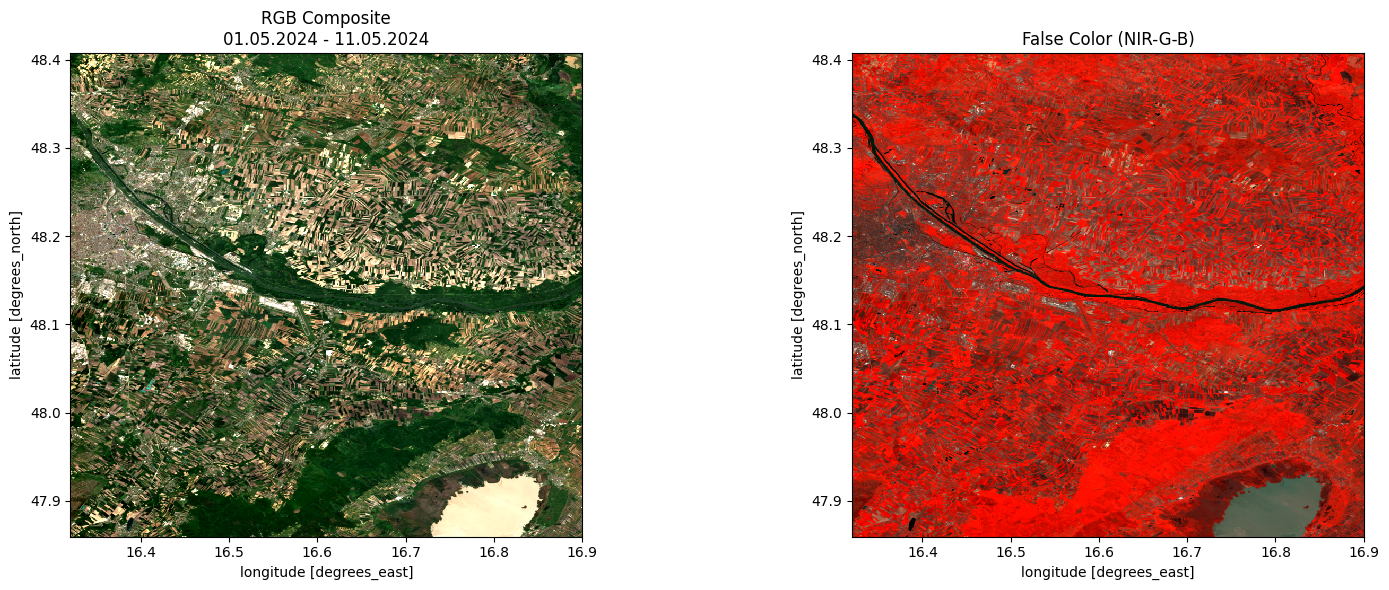

In [4]:
# Compute median composites
rgb_median = (
    dc_valid[["red", "green", "blue"]]
    .to_dataarray(dim="band")
    .median(dim="time")
    .astype(int)
    .compute()
)

fc_median = (
    dc_valid[["nir", "green", "blue"]]
    .to_dataarray(dim="band")
    .transpose(..., "band")
    .median(dim="time")
    .astype(int)
    .compute()
)

# Plot both
fig1, axes1 = plt.subplots(1, 2, figsize=(16, 6))
rgb_median.plot.imshow(ax=axes1[0], robust=True)
axes1[0].set_title(
    f"RGB Composite\n{start_date.strftime('%d.%m.%Y')} - {end_date.strftime('%d.%m.%Y')}"
)
axes1[0].set_aspect("equal")

fc_median.plot.imshow(ax=axes1[1], robust=True)
axes1[1].set_title("False Color (NIR-G-B)")
axes1[1].set_aspect("equal")

plt.tight_layout()

---
## Part 1: Training Data Design

We define training polygons for four classes: **forest**, **agriculture**, **urban**, and **water**.

Key considerations:
- **Forest**: Dense tree cover in Vienna Woods (southeast)
- **Agriculture**: Active cropland and vineyards (north and west)
- **Urban**: Dense city center AND suburban areas
- **Water**: Danube River and lakes

In [178]:
# training_polys.to_parquet("training_polys_final.parquet")
training_polys = gpd.read_file(
    "overture_polys.geojson"
)  # = gpd.read_parquet("training_polys_final.parquet")

In [181]:
print(training_polys.columns)

class_map = training_polys["class"].unique()
training_polys["class_id"] = training_polys["class"].astype("category").cat.codes
print(
    dict(
        zip(
            training_polys["class"].astype("category").cat.categories,
            range(len(class_map)),
        )
    )
)

Index(['id', 'class', 'geometry'], dtype='object')
{'barren': 0, 'crop': 1, 'forest': 2, 'grass': 3, 'shrub': 4, 'urban': 5, 'wetland': 6}


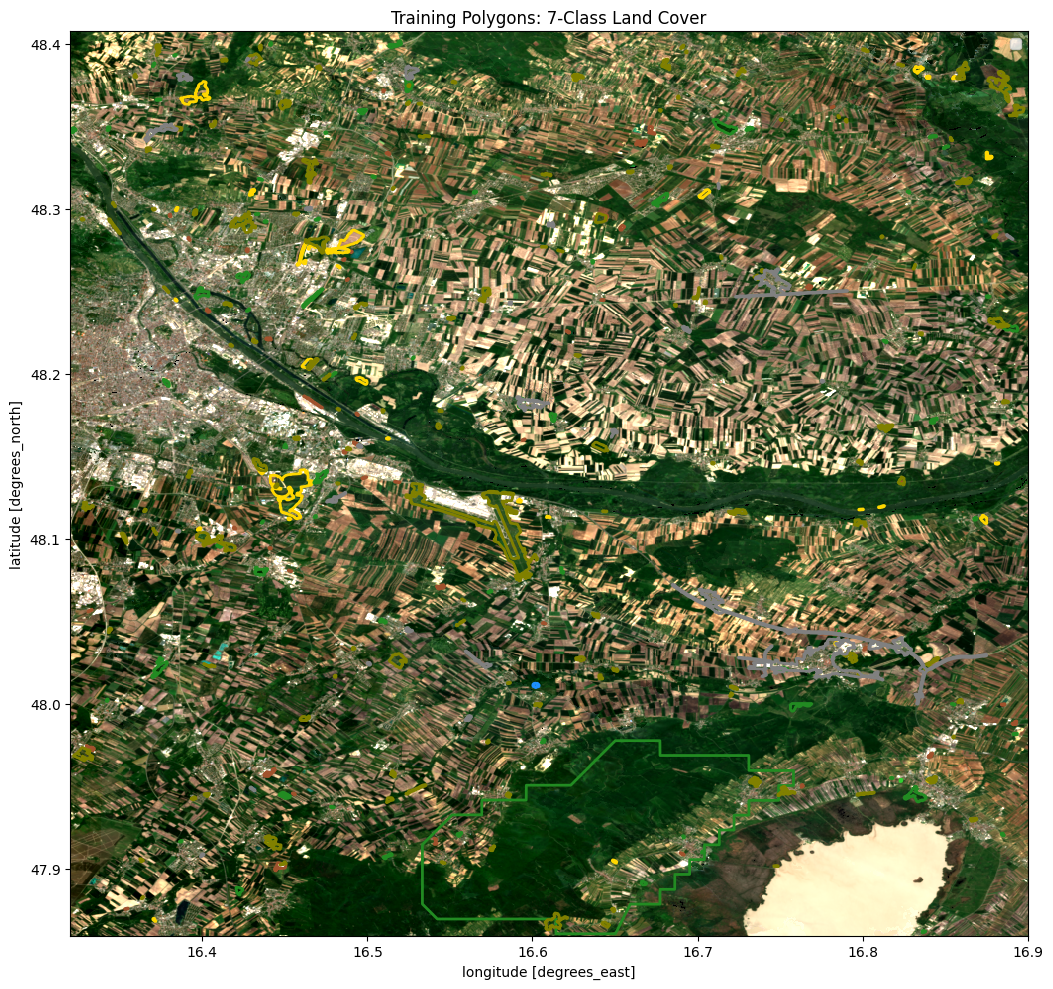

In [182]:
class_names = ["barren", "crop", "forest", "grass", "shrub", "urban", "wetland"]
class_colors = [
    "sienna",
    "gold",
    "forestgreen",
    "limegreen",
    "olive",
    "gray",
    "dodgerblue",
]

fig2, ax2 = plt.subplots(figsize=(12, 10))
rgb_median.plot.imshow(ax=ax2, robust=True)
for _name, _color in zip(class_names, class_colors):
    _subset = training_polys[training_polys["class"] == _name]
    if len(_subset) > 0:
        _subset.plot(
            ax=ax2, facecolor="none", edgecolor=_color, linewidth=2, label=_name
        )
ax2.legend(loc="upper right")
ax2.set_title("Training Polygons: 7-Class Land Cover")
ax2.set_aspect("equal")
plt.tight_layout()

Number of polygons per class:
class
barren      46
crop        35
forest      79
grass        1
shrub      153
urban       25
wetland      1
dtype: int64



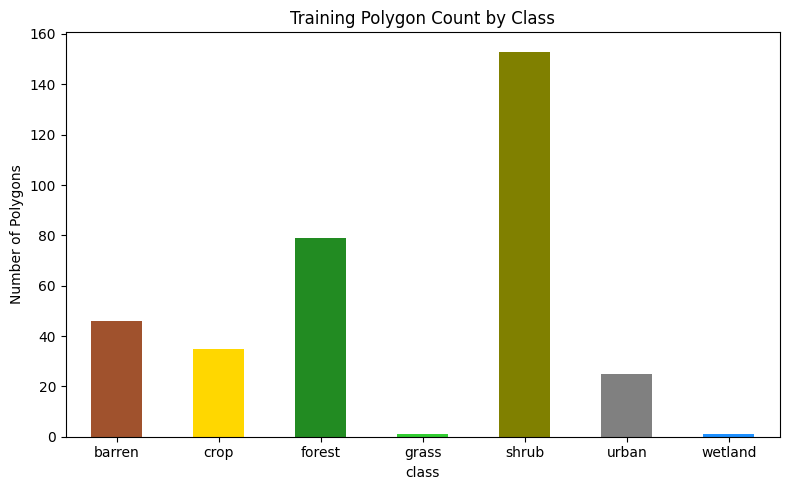

In [183]:
class_counts = training_polys.groupby("class").size()
class_counts = class_counts.reindex(class_names)

print("Number of polygons per class:")
print(class_counts)
print()

color_map = dict(zip(class_names, class_colors))
bar_colors = [color_map[c] for c in class_counts.index]

fig3, ax3 = plt.subplots(figsize=(8, 5))
class_counts.plot(kind="bar", ax=ax3, color=bar_colors)
ax3.set_ylabel("Number of Polygons")
ax3.set_title("Training Polygon Count by Class")
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
plt.tight_layout()

### Class Balance Considerations

**Observations:**
- Forest has more polygons than other classes
- Water has fewest polygons (Danube is a thin linear feature)

**Potential problems with imbalance:**
- Model may be biased toward majority class
- Minority class (water) may have poor recall

**Strategies to address:**
- Undersample majority class
- Oversample minority class (e.g., SMOTE)
- Use class weights in the classifier
- Ensure evaluation metrics account for imbalance (balanced accuracy, macro F1)

We'll use `class_weight='balanced'` in Random Forest to handle this automatically.

In [154]:
ds_median = (
    dc_valid[["red", "green", "blue", "nir", "swir16"]].median(dim="time").compute()
)

red_med = ds_median.red
green_med = ds_median.green
blue_med = ds_median.blue
nir_med = ds_median.nir
swir_med = ds_median.swir16

In [155]:
# Create feature dataset with all bands and indices
ds_features = xr.Dataset(
    {
        "red": red_med,
        "green": green_med,
        "blue": blue_med,
        "nir": nir_med,
        "swir16": swir_med,
    }
).fillna(0)

feature_names = ["red", "green", "blue", "nir", "swir16"]
ds_features

<xarray.Dataset> Size: 18MB
Dimensions:      (latitude: 913, longitude: 967)
Coordinates:
  * latitude     (latitude) float64 7kB 48.41 48.41 48.41 ... 47.86 47.86 47.86
  * longitude    (longitude) float64 8kB 16.32 16.32 16.32 ... 16.9 16.9 16.9
    spatial_ref  int32 4B 4326
Data variables:
    red          (latitude, longitude) float32 4MB 259.5 336.0 ... 678.5 691.5
    green        (latitude, longitude) float32 4MB 545.0 609.0 ... 813.5 769.5
    blue         (latitude, longitude) float32 4MB 275.5 358.0 ... 549.0 538.5
    nir          (latitude, longitude) float32 4MB 4.46e+03 ... 2.578e+03
    swir16       (latitude, longitude) float32 4MB 1.884e+03 ... 2.157e+03

In [185]:
n_per_polygon = 100

X_list = []
y_list = []
group_list = []


def extract_pixels_from_polygon(ds, geometry, feature_list):
    """Extract pixel values from a polygon"""
    try:
        clipped = ds.rio.clip([geometry], all_touched=False, drop=True)
        arr = clipped.to_array(dim="band").values
        n_features = len(feature_list)
        pixels = arr.reshape(n_features, -1).T
        return pixels
    except Exception:
        return np.array([]).reshape(0, len(feature_list))


for idx, row in training_polys.iterrows():
    pixels = extract_pixels_from_polygon(ds_features, row.geometry, feature_names)
    if len(pixels) > 0:
        _valid_mask = ~np.isnan(pixels).any(axis=1)
        pixels = pixels[_valid_mask]
        if len(pixels) > 0:
            if len(pixels) > n_per_polygon:
                sample_idx = np.random.choice(
                    len(pixels), size=n_per_polygon, replace=False
                )
                pixels = pixels[sample_idx]
            X_list.append(pixels)
            y_list.append(np.full(len(pixels), row.class_id))
            group_list.append(np.full(len(pixels), idx))

X_all = np.concatenate(X_list)
y_all = np.concatenate(y_list)
groups_all = np.concatenate(group_list)

print(f"Total training pixels: {len(X_all)}")
print(f"Pixels per class:")
for _i, _name in enumerate(class_names):
    print(f"  {_name}: {(y_all == _i).sum()}")

Total training pixels: 11158
Pixels per class:
  barren: 882
  crop: 1248
  forest: 2359
  grass: 4
  shrub: 5401
  urban: 1234
  wetland: 30


---
## Part 3: Multi-Class Classification and Evaluation

In [186]:
# Split data 70/30, stratified by class
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X_all, y_all, groups_all, test_size=0.3, random_state=42, stratify=y_all
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest with balanced class weights
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_scaled, y_train)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 7810
Testing samples: 3348


In [187]:
# Predictions
y_pred = rf_clf.predict(X_test_scaled)

# Predict on full image
image_data = (
    ds_features[feature_names]
    .to_array(dim="band")
    .transpose("latitude", "longitude", "band")
)

img_shape = (ds_features.sizes["latitude"], ds_features.sizes["longitude"])
X_image = image_data.values.reshape(-1, len(feature_names))
X_image_scaled = scaler.transform(X_image)

y_pred_img = rf_clf.predict(X_image_scaled).reshape(img_shape)

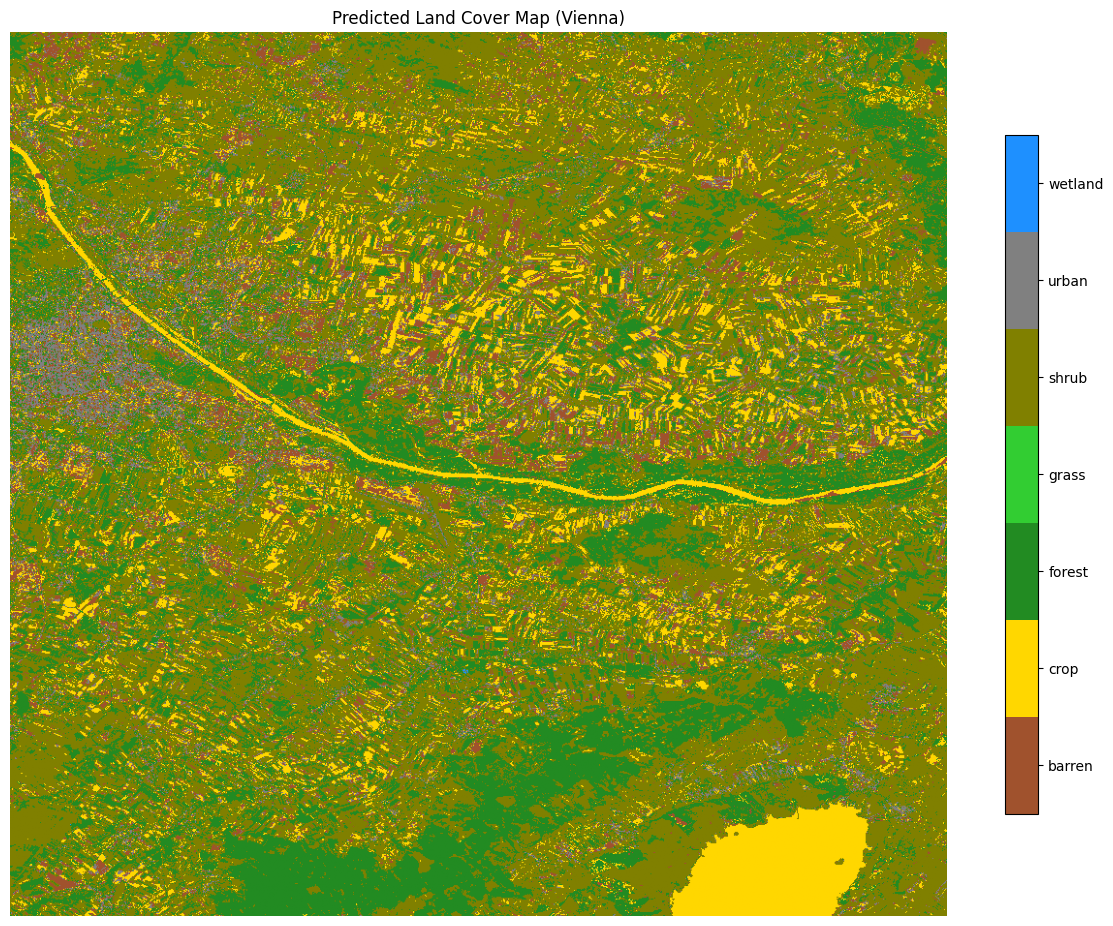

In [191]:
cmap_lc = mcolors.ListedColormap(class_colors)
fig5, ax5 = plt.subplots(figsize=(12, 10))
im = ax5.imshow(y_pred_img, cmap=cmap_lc, vmin=0, vmax=6)
ax5.set_title("Predicted Land Cover Map (Vienna)")
ax5.axis("off")
ticks = [i * (6 / 7) + (6 / 14) for i in range(7)]
cbar = plt.colorbar(im, ax=ax5, ticks=ticks, shrink=0.7)
cbar.set_ticklabels(class_names)
plt.tight_layout()

### Visual Inspection

**Look for:**
- Do forest areas (Vienna Woods in SE) appear green?
- Is the Danube River classified as water (blue)?
- Are dense urban areas correctly identified (gray)?
- Are agricultural areas in the north classified correctly (gold)?

**Common errors:**
- Agricultural and forest confusion (both vegetation)
- Urban parks misclassified as forest
- River edges mixed with urban

Classification Report:
              precision    recall  f1-score   support

      barren       0.49      0.13      0.21       265
        crop       0.41      0.09      0.15       374
      forest       0.40      0.15      0.21       708
       grass       0.00      0.00      0.00         1
       shrub       0.51      0.90      0.65      1621
       urban       0.26      0.05      0.08       370
     wetland       0.00      0.00      0.00         9

    accuracy                           0.49      3348
   macro avg       0.30      0.19      0.19      3348
weighted avg       0.45      0.49      0.40      3348



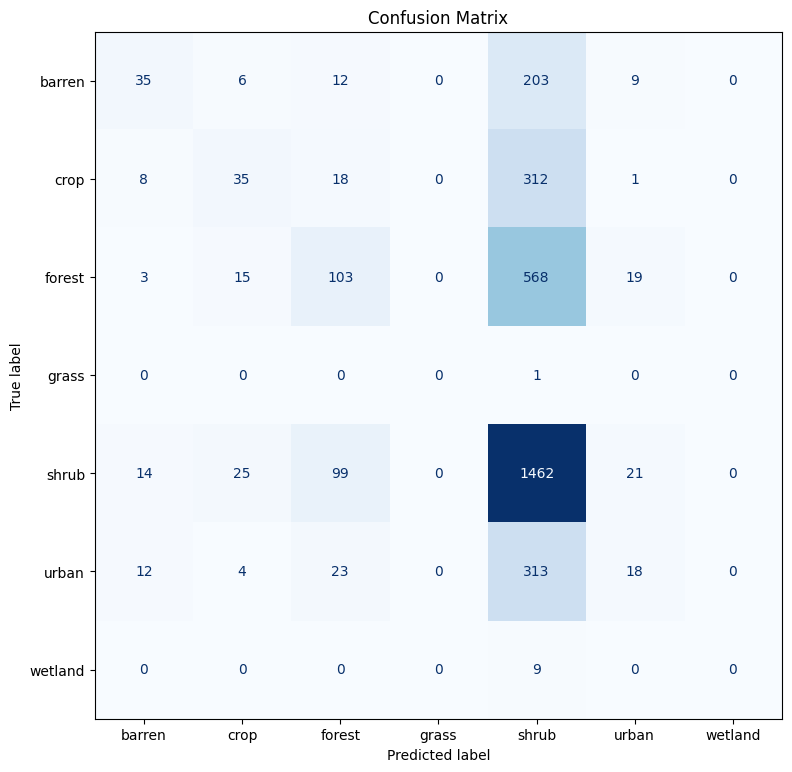

In [189]:
# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=class_names))

fig6, ax6 = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(
    ax=ax6, cmap="Blues", colorbar=False
)
ax6.set_title("Confusion Matrix")
plt.tight_layout()

### Which classes are most commonly confused?

**Typical patterns:**
- **Forest ↔ Agriculture**: Both have high vegetation signal; spectral overlap
- **Urban ↔ Agriculture**: Bare fields can look like urban spectrally
- **Water edges**: Often confused with dark urban surfaces

The confusion matrix reveals where class boundaries are weakest.

In [192]:
# Compare evaluation metrics
acc = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("Evaluation Metrics Comparison")
print("=" * 40)
print(f"Overall Accuracy:    {acc:.4f}")
print(f"Balanced Accuracy:   {balanced_acc:.4f}")
print(f"Macro-averaged F1:   {macro_f1:.4f}")

Evaluation Metrics Comparison
Overall Accuracy:    0.4937
Balanced Accuracy:   0.1888
Macro-averaged F1:   0.1868


### Why might these metrics differ?

- **Overall Accuracy**: Proportion correct, but dominated by majority class
- **Balanced Accuracy**: Average recall across classes — treats all classes equally
- **Macro F1**: Average F1 across classes — balances precision and recall

**When to use each:**
- **Accuracy**: When classes are balanced and all equally important
- **Balanced Accuracy**: When class sizes differ but you care equally about all
- **Macro F1**: When you want to penalize poor performance on any class

**For a stakeholder**: Report balanced accuracy or macro F1, since they don't hide poor performance on minority classes (water).

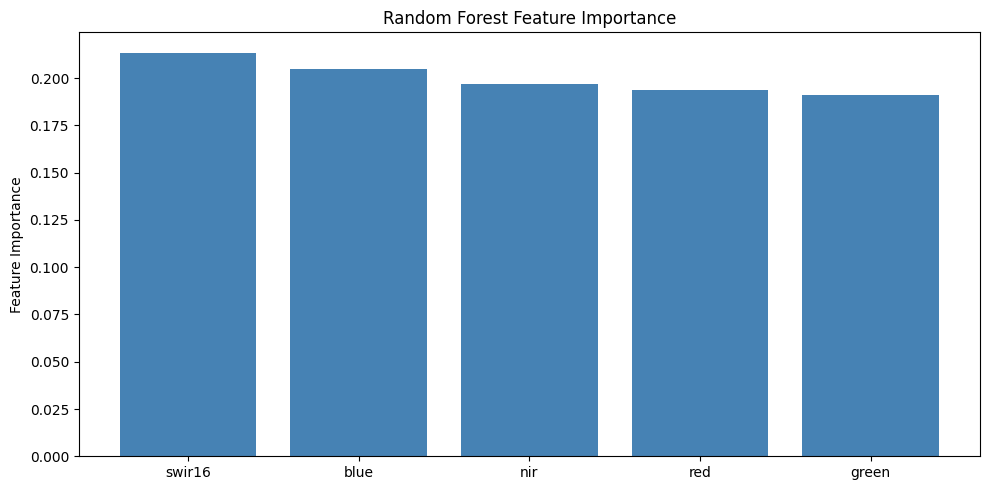

In [193]:
# Feature importance
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

fig7, ax7 = plt.subplots(figsize=(10, 5))
ax7.bar(range(len(feature_names)), importances[indices], color="steelblue")
ax7.set_xticks(range(len(feature_names)))
ax7.set_xticklabels([feature_names[i] for i in indices])
ax7.set_ylabel("Feature Importance")
ax7.set_title("Random Forest Feature Importance")
plt.tight_layout()

### Feature Importance Analysis

**Key questions:**
- Are the spectral indices (NDVI, MNDWI, NDBI) more important than raw bands?
- Which features contribute most to classification?

**Typically:**
- NIR and SWIR are highly important (key for vegetation vs urban vs water)
- NDVI often ranks high for distinguishing vegetation
- MNDWI is crucial for water detection

---
## Part 4: Spatial Cross-Validation

**Problem with random splits:**
- Pixels from the same polygon are in both train and test sets
- Due to **spatial autocorrelation**, neighboring pixels are very similar
- This inflates accuracy estimates — the model may just be memorizing local patterns

**Solution: GroupKFold**
- Hold out entire polygons, not random pixels
- Tests model's ability to generalize to truly unseen areas

In [195]:
from sklearn.model_selection import StratifiedGroupKFold

# Spatial cross-validation with GroupKFold
n_splits = 5

sgkf = StratifiedGroupKFold(n_splits=5)

spatial_cv_scores = []

for train_idx, test_idx in sgkf.split(X_all, y_all, groups_all):
    X_train_cv = X_all[train_idx]
    X_test_cv = X_all[test_idx]
    y_train_cv = y_all[train_idx]
    y_test_cv = y_all[test_idx]

    # Scale
    scaler_cv = scaler.__class__()
    X_train_cv_scaled = scaler_cv.fit_transform(X_train_cv)
    X_test_cv_scaled = scaler_cv.transform(X_test_cv)

    # Train and evaluate
    rf_cv = rf_clf.__class__(n_estimators=100, random_state=42, n_jobs=-1)
    rf_cv.fit(X_train_cv_scaled, y_train_cv)
    score = rf_cv.score(X_test_cv_scaled, y_test_cv)
    spatial_cv_scores.append(score)

print("Spatial Cross-Validation (StratifiedGroupKFold)")
print("=" * 40)
print(f"Fold accuracies: {[f'{s:.4f}' for s in spatial_cv_scores]}")
print(
    f"Mean accuracy: {np.mean(spatial_cv_scores):.4f} ± {np.std(spatial_cv_scores):.4f}"
)

Spatial Cross-Validation (StratifiedGroupKFold)
Fold accuracies: ['0.4692', '0.4847', '0.4526', '0.4477', '0.4702']
Mean accuracy: 0.4649 ± 0.0133


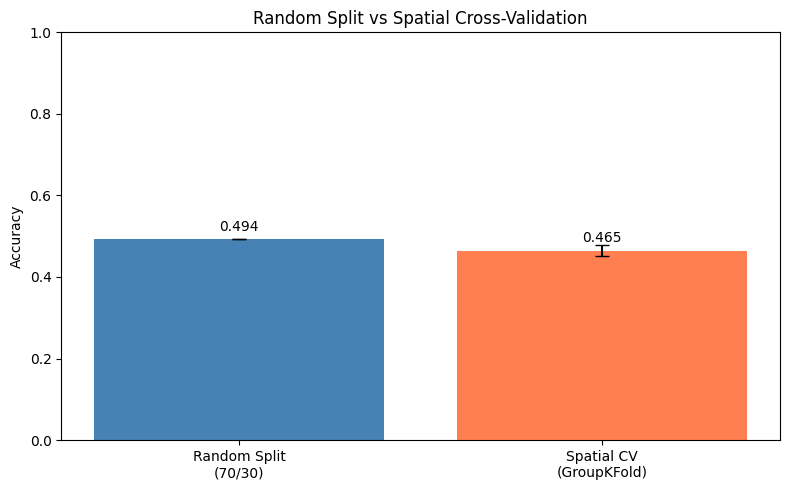

In [196]:
# Compare random vs spatial CV
fig8, ax8 = plt.subplots(figsize=(8, 5))

metrics = ["Random Split\n(70/30)", "Spatial CV\n(GroupKFold)"]
values = [acc, np.mean(spatial_cv_scores)]
errors = [0, np.std(spatial_cv_scores)]

bars = ax8.bar(metrics, values, yerr=errors, capsize=5, color=["steelblue", "coral"])
ax8.set_ylabel("Accuracy")
ax8.set_title("Random Split vs Spatial Cross-Validation")
ax8.set_ylim(0, 1)

for bar, val in zip(bars, values):
    ax8.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        f"{val:.3f}",
        ha="center",
    )

plt.tight_layout()

### What does the performance drop tell us?

**Interpretation:**
- If spatial CV accuracy is much lower than random split accuracy, the model is **overfitting to local patterns**
- The drop indicates how much accuracy would decrease when applying the model to truly new areas
- This is a more realistic estimate of real-world performance

**The larger the gap, the more the model relies on memorizing training polygon characteristics rather than learning generalizable patterns.**

---
## Part 5: Model Transfer to Damascus, Syria

Now we test whether our Vienna-trained model can generalize to a completely different geography.

In [44]:
# Load Sentinel-2 data for Damascus
damascus_bounds = (36.2, 33.4, 36.5, 33.6)

# Same time period as Vienna
damascus_start = datetime(year=2024, month=5, day=1)
damascus_end = damascus_start + timedelta(days=10)
damascus_date_query = (
    f"{damascus_start.strftime('%Y-%m-%d')}/{damascus_end.strftime('%Y-%m-%d')}"
)

damascus_items = stac_client.search(
    bbox=damascus_bounds,
    collections=["sentinel-2-l2a"],
    datetime=damascus_date_query,
    limit=100,
).item_collection()

print(f"Damascus: {len(damascus_items)} scenes found")

damascus_geobox = GeoBox.from_bbox(damascus_bounds, crs=f"epsg:{epsg}", resolution=dx)

dc_damascus = odc.stac.load(
    damascus_items,
    bands=["scl", "red", "green", "blue", "nir", "swir16"],
    chunks={"time": 5, "x": 600, "y": 600},
    geobox=damascus_geobox,
    resampling="bilinear",
)
dc_damascus

Damascus: 12 scenes found


<xarray.Dataset> Size: 22MB
Dimensions:      (latitude: 334, longitude: 501, time: 12)
Coordinates:
  * latitude     (latitude) float64 3kB 33.6 33.6 33.6 33.6 ... 33.4 33.4 33.4
  * longitude    (longitude) float64 4kB 36.2 36.2 36.2 36.2 ... 36.5 36.5 36.5
  * time         (time) datetime64[ns] 96B 2024-05-01T08:20:49.136000 ... 202...
    spatial_ref  int32 4B 4326
Data variables:
    scl          (time, latitude, longitude) uint8 2MB dask.array<chunksize=(5, 334, 501), meta=np.ndarray>
    red          (time, latitude, longitude) uint16 4MB dask.array<chunksize=(5, 334, 501), meta=np.ndarray>
    green        (time, latitude, longitude) uint16 4MB dask.array<chunksize=(5, 334, 501), meta=np.ndarray>
    blue         (time, latitude, longitude) uint16 4MB dask.array<chunksize=(5, 334, 501), meta=np.ndarray>
    nir          (time, latitude, longitude) uint16 4MB dask.array<chunksize=(5, 334, 501), meta=np.ndarray>
    swir16       (time, latitude, longitude) uint16 4MB dask.array<chunksize=(5, 334, 501), meta=np.ndarray>

In [23]:
# Cloud masking for Damascus
valid_mask_dam = is_valid_pixel(dc_damascus.scl)
dc_damascus_valid = dc_damascus.where(valid_mask_dam)

In [24]:
# Compute features for Damascus
red_dam = dc_damascus_valid.red.median(dim="time")
green_dam = dc_damascus_valid.green.median(dim="time")
blue_dam = dc_damascus_valid.blue.median(dim="time")
nir_dam = dc_damascus_valid.nir.median(dim="time")
swir_dam = dc_damascus_valid.swir16.median(dim="time")

ds_features_dam = xr.Dataset(
    {
        "red": red_dam,
        "green": green_dam,
        "blue": blue_dam,
        "nir": nir_dam,
        "swir16": swir_dam,
    }
).fillna(0)

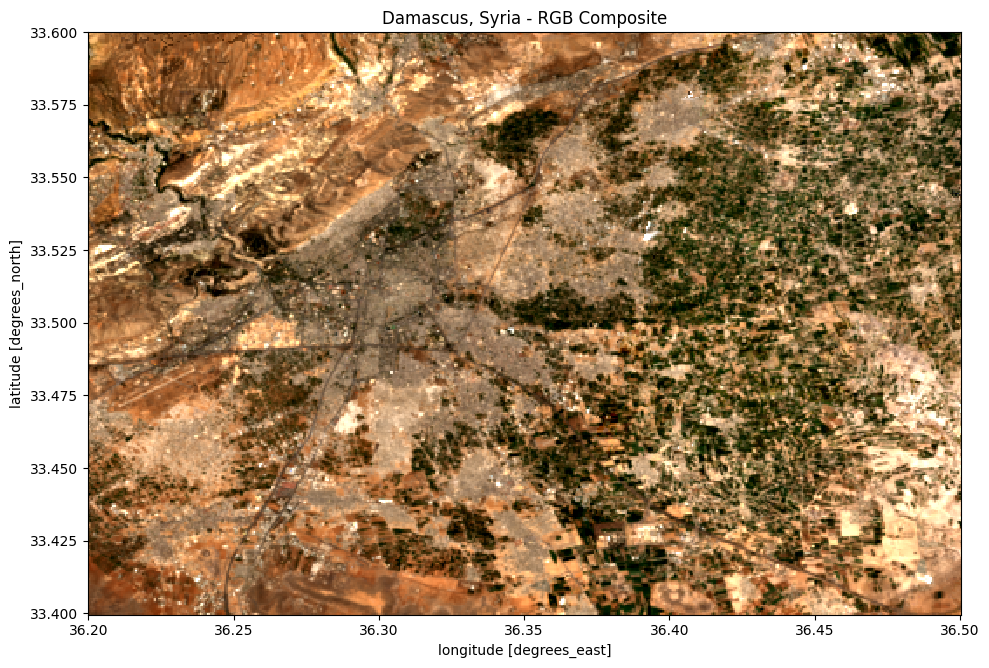

In [25]:
# Damascus RGB composite
rgb_damascus = (
    dc_damascus_valid[["red", "green", "blue"]]
    .to_dataarray(dim="band")
    .median(dim="time")
    .astype(int)
)

fig9, ax9 = plt.subplots(figsize=(10, 8))
rgb_damascus.plot.imshow(ax=ax9, robust=True)
ax9.set_title("Damascus, Syria - RGB Composite")
ax9.set_aspect("equal")
plt.tight_layout()

In [197]:
# Apply Vienna model to Damascus
image_data_dam = (
    ds_features_dam[feature_names]
    .to_array(dim="band")
    .transpose("latitude", "longitude", "band")
)

img_shape_dam = (ds_features_dam.sizes["latitude"], ds_features_dam.sizes["longitude"])
X_image_dam = image_data_dam.values.reshape(-1, len(feature_names))
X_image_dam_scaled = scaler.transform(X_image_dam)

y_pred_dam = rf_clf.predict(X_image_dam_scaled).reshape(img_shape_dam)

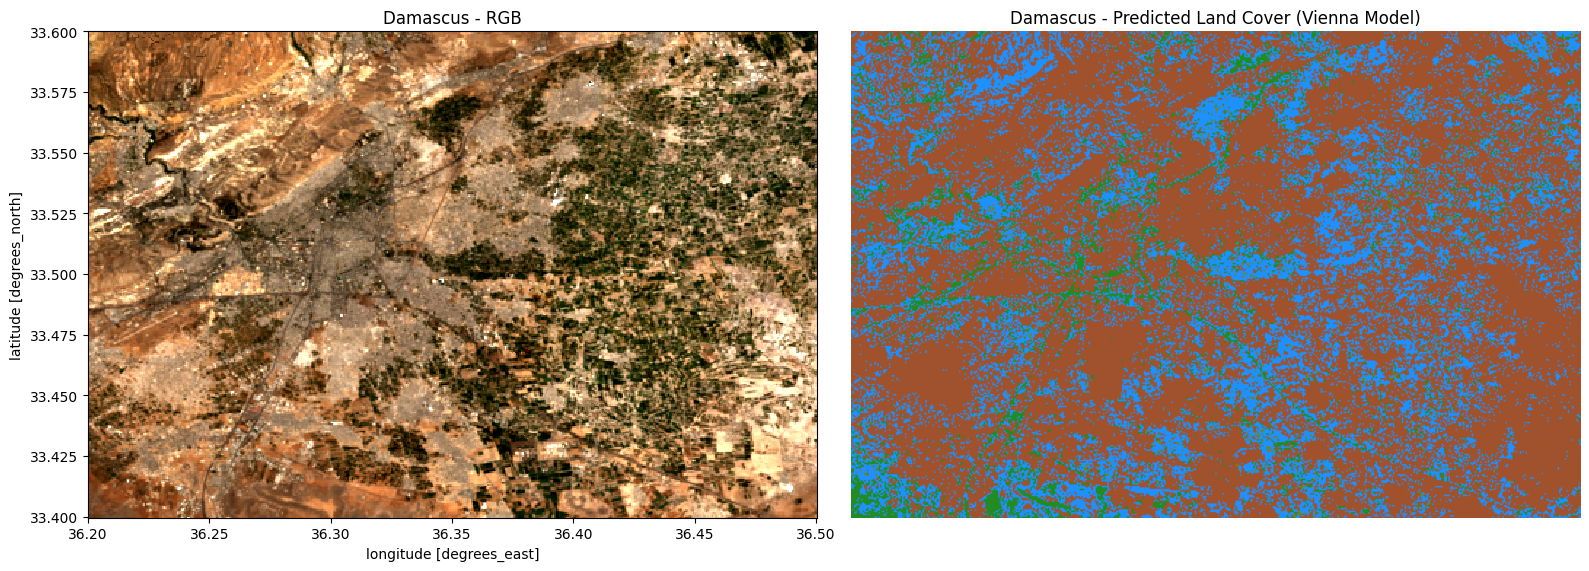

In [200]:
# Compare RGB and predictions for Damascus
fig10, axes10 = plt.subplots(1, 2, figsize=(16, 7))

rgb_damascus.plot.imshow(ax=axes10[0], robust=True)
axes10[0].set_title("Damascus - RGB")
axes10[0].set_aspect("equal")

cmap_lc_dam = mcolors.ListedColormap(class_colors)
im_dam = axes10[1].imshow(y_pred_dam, cmap=cmap_lc, vmin=0, vmax=3)
axes10[1].set_title("Damascus - Predicted Land Cover (Vienna Model)")
axes10[1].axis("off")

cbar = plt.colorbar(im, ax=ax5, ticks=ticks, shrink=0.7)
cbar.set_ticklabels(class_names)

plt.tight_layout()

Comparing the RGB image of Damascus to our predicted land cover, we notice that our predictions are pretty solid in urban areas buuuuuut that's about all they're good at. The model struggles to identify what appear to be vegetated areas in the outskirts of Damascus--perhaps since the type of vegetation is very different from what you'd see in Vienna--and it also doesn't recognize desert/bare soil. This is a clear case of a model not generalizing well to a new context and out-of-sample observations (since there's no desert in Vienna). We'd like want to train an entirely new model for this area!